2021-11-09 19:06:19.688166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-09 19:06:19.688254: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First 1 elements of X_test:


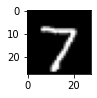

Invalid argument in __init__: transformer does not have function inverse_transform - default returns fitted X
First 1 elements of X_train:


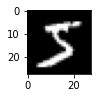

X_train[:5, :]: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y_train[:5, :]: [[5]
 [0]
 [4]
 [1]
 [9]]


/home/will/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification accuracy on Training Data: 0.132
Classes of X_test[:5, :]: [[7]
 [2]
 [1]
 [0]
 [4]]
Predicted classes of X_test[:5, :]: [1 1 1 1 1]
Classification accuracy: 0.134

Warning in encode(): model does not have encoder - returning input
Warning in encode(): model does not have encoder - returning input
Warning in encode(): model does not have encoder - returning input
Warning in encode(): model does not have encoder - returning input
Processing KERNELKDE
--Row 0
--Row 1
--Row 2
--Row 3
--Row 4
--Row 5
--Row 6
--Row 7
--Row 8
--Row 9
--Row 10
--Row 11
--Row 12
--Row 13
--Row 14
--Row 15
--Row 16
--Row 17
--Row 18
--Row 19
--Row 20
--Row 21
--Row 22
--Row 23
--Row 24
--Row 25
--Row 26
--Row 27
--Row 28
--Row 29
--Row 30
--Row 31
--Row 32
--Row 33
--Row 34
--Row 35
--Row 36
--Row 37
--Row 38
--Row 39
--Row 40
--Row 41
--Row 42
--Row 43
--Row 44
--Row 45
--Row 46
--Row 47
--Row 48
--Row 49
--Row 50
--Row 51
--Row 52
--Row 53
--Row 54
--Row 55
--Row 56
--Row 57
--Row 58
--Row 59
-

In [ ]:
import csv
import requests

import os
import sys
import inspect

sys.path.insert(1, os.path.join(sys.path[0], '..'))

import matplotlib.pyplot as plt
import fatapi
from fatapi.data import Data
from fatapi.model import BlackBox, Model, DensityEstimator, Transformer
import numpy as np
from fatapi.methods import FACEMethod
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, Normalizer

from keras.datasets import mnist

# load MNIST dataset from local .csv files
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = ""
#train_data = np.loadtxt(data_path + "mnist_train.csv", 
#                        delimiter=",")
#test_data = np.loadtxt(data_path + "mnist_test.csv", 
#                       delimiter=",")
#train_imgs = np.asfarray(train_data[:, 1:])
#train_labels = np.asfarray(train_data[:, :1])
#test_imgs = np.asfarray(test_data[:, 1:])
#test_labels = np.asfarray(test_data[:, :1])
# load dataset - data to be used by the Model and for counterfactual generation
#X_train, y_train, X_test, y_test = train_imgs, train_labels, test_imgs, test_labels
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train = X_train[:500, :]
y_train = y_train[:500, :]
X_test = X_test[:500, :]
y_test = y_test[:500, :]

row_indicies = [0] #[0, 1, 2, 3, 4]
print(f"First {len(row_indicies)} elements of X_test:")
for i in row_indicies:
    # define subplot
    img = X_test[i].reshape((image_size,image_size))
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

myencoder = Transformer(transformer=OneHotEncoder())
myscaler = Transformer(transformer=Normalizer())

# Data object wrapper for dataset and targets of dataset - dtype provides default column indicies for categoricals/numericals
data_X = Data(dataset=X_train, dtype="data")
data_y = Data(dataset=y_train, dtype="target", encoded=True)

# datapoints in X to be used as factuals, wrapped in a Data object
factuals = data_X.get_rows_as_data(row_indicies)
# targets of datapoints in X to be used as factual targets, wrapped in a Data object
factuals_target = data_y.get_rows_as_data(row_indicies)

# has to return a boolean 
def conditionf(**kwargs):
    return True

print(f"First {len(row_indicies)} elements of X_train:")
for i in row_indicies:
    # define subplot
    img = X_train[i].reshape((image_size,image_size))
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

print(f"X_train[:5, :]: {X_train[:5, :]}")
print(f"y_train[:5, :]: {y_train[:5, :]}")

# any classifier model with predict, predict_proba, fit and score methods
clf = svm.SVC(gamma=0.01)
# wrapper for any classifier to be used by Methods / Models;
#  clf has to have predict, predict_proba, score and fit methods
# blackb = BlackBox(clf)

# Model wrapper - includes blackbox and optional encoder, scaler
face_model = Model(data_X, data_y, fit=clf.fit, predict=clf.predict, predict_proba=clf.decision_function, score=clf.score, 
                   scaler=myscaler) #encoder=myencoder
face_model.train()

print(f"Classes of X_test[:5, :]: {y_test[:5, :]}")
print(f"Predicted classes of X_test[:5, :]: {clf.predict(X_test[:5, :])}")
print(f"Classification accuracy: {clf.score(X_test, y_test)}\n")

# grid search to find a good KernelDensity estimator (sklearn)
bandwidths = 10 ** np.linspace(-2, 1, 100)  
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=20)
grid.fit(data_X.dataset)
dens_est = grid.best_estimator_

# wrapper for any density estimator ('estimator' has to have fit, score_samples) to be used by FACEMethod
_dens_est = DensityEstimator(
    estimator=dens_est)

# the FACE algorithm with most of the parameters available; required parameters and object specification
# can be seen in the source code
face_method = FACEMethod(factuals=factuals, 
                         factuals_target=factuals_target, 
                         model=face_model, kernel_type="kde", 
                         t_prediction=0.5, epsilon=0.7,
                         t_density=0.0, t_radius_limit=1.10, n_neighbours=20,
                         K=10, conditions=conditionf, density_estimator=_dens_est)
# the main explain() method to generate counterfactuals
print(f"Counterfactuals (return of explain()): {face_method.explain()}\n")
print(f"Graph [Distances - N_samples x N_samples]: \n{face_method.get_graph()}\n")
print(f"Graph = Graph + face_method.get_start_node_edges() if the start node counterfactual is not in X")
print(f"Paths [Indexes]: {face_method.get_explain_paths()}\n")
print(f"Candidates for Counterfactuals [Indexes]: {face_method.get_explain_candidates()}")

counterfactuals_as_indexes = face_method.get_counterfactuals(as_indexes=True)
counterfactuals = face_method.get_counterfactuals()
counterfactuals_data, counterfactuals_target = face_method.get_counterfactuals_as_data()

print(f"Counterfactuals [Indexes]: {face_method.get_counterfactuals(True)}")

print(f"\nfor factual X[{row_indicies[0]}] (as data: {factuals.dataset[0]}), the counterfactual is X[{counterfactuals_as_indexes[0]}] (as classification: {counterfactuals[0]})")
print(f"\nCounterfactual for X[0] (X[6]) as target (Y) and data (X): \nX[{counterfactuals_as_indexes[0]}]: {counterfactuals_data[0]}, Y[{counterfactuals_as_indexes[0]}]: {counterfactuals_target[0]}")